# Bahdanau 注意力
:label:`sec_seq2seq_attention`

我们在 :numref:`sec_seq2seq` 中探讨了机器翻译问题，在那里我们设计了一个基于两个循环神经网络的编码器-解码器结构，用于序列到序列的学习。具体来说，循环神经网络编码器将可变长度序列转换为固定形状的上下文变量，然后循环神经网络解码器根据生成的词元和上下文变量按词元生成输出（目标）序列词元。但是，即使并非所有输入（源）词元都对解码某个词元都有用，但在每个解码步骤中仍使用编码整个输入序列的*相同*上下文变量。

在为给定文本序列生成手写的挑战中，格雷夫斯设计了一种可微注意力模型，将文本字符与更长的笔迹对齐，其中对齐方式仅向一个方向移动 :cite:`Graves.2013`。受学习对齐想法的启发，Bahdanau 等人提出了一个没有严格的单向对齐限制 :cite:`Bahdanau.Cho.Bengio.2014` 的可微注意力模型。在预测词元时，如果不是所有输入词元都相关，模型将仅对齐（或参与）输入序列中与当前预测相关的部分。这是通过将上下文变量视为注意力集中的输出来实现的。

## 模型

在下面描述 Bahdanau 注意力对循环神经网络编码器的关注时，我们将遵循 :numref:`sec_seq2seq` 中的相同符号表达。新的基于注意力的模型与 :numref:`sec_seq2seq` 中的模型相同，只不过 :eqref:`eq_seq2seq_s_t` 中的上下文变量 $\mathbf{c}$ 在任何解码时间步骤 $t'$ 都会被 $\mathbf{c}_{t'}$ 替换。假设输入序列中有 $T$ 个词元，解码时间步长 $t'$ 的上下文变量是注意力集中的输出：

$$\mathbf{c}_{t'} = \sum_{t=1}^T \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_t) \mathbf{h}_t,$$

其中，时间步 $t' - 1$ 时的解码器隐藏状态 $\mathbf{s}_{t' - 1}$ 是查询，编码器隐藏状态 $\mathbf{h}_t$ 既是键，也是值，注意力权重 $\alpha$ 是使用 :eqref:`eq_attn-scoring-alpha` 所定义的加性注意力打分函数计算的。

与 :numref:`fig_seq2seq_details` 中的循环神经网络编码器-解码器结构略有不同， :numref:`fig_s2s_attention_details` 描述了 Bahdanau 注意力的结构。

![在一个带有Bahdanau注意力的循环神经网络编码器-解码器模型中的层。](../img/seq2seq-attention-details.svg)
:label:`fig_s2s_attention_details`


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


## 定义注意力解码器

要用 Bahdanau 注意力实现循环神经网络编码器-解码器，我们只需重新定义解码器即可。为了更方便地显示学习的注意力权重，以下 `AttentionDecoder` 类定义了[**带有注意力机制的解码器基本接口**]。


In [2]:
#@save
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制的解码器基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

接下来，让我们在接下来的 `Seq2SeqAttentionDecoder` 类中[**实现带有Bahdanau注意力的循环神经网络解码器**]。初始化解码器的状态 （1）编码器在所有时间步的最终层隐藏状态（作为注意力的键和值）；（2）最后一个时间步的编码器全层隐藏状态（初始化解码器的隐藏状态）；（3）编码器有效长度（排除在注意力池中填充词元）。在每个解码时间步骤中，解码器上一个时间步的最终层隐藏状态将用作关注的查询。因此，注意力输出和输入嵌入都连接为循环神经网络解码器的输入。


In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # `enc_outputs`的形状为 (`batch_size`, `num_steps`, `num_hiddens`).
        # `hidden_state`的形状为 (`num_layers`, `batch_size`,
        # `num_hiddens`)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # `enc_outputs`的形状为 (`batch_size`, `num_steps`, `num_hiddens`).
        # `hidden_state`的形状为 (`num_layers`, `batch_size`,
        # `num_hiddens`)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出 `X`的形状为 (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # `query`的形状为 (`batch_size`, 1, `num_hiddens`)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # `context`的形状为 (`batch_size`, 1, `num_hiddens`)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)#
                #返回的是一个enc_ouputs的权重
            #(b,q的时间步数,也是最后结果预测的数量,val的最后一维)
            #所以返回的是一个词的向量,里面每一个值是词向量的元素softmax值,不用在乎queries,而在乎他们决定的数据尺寸
            # 在特征维度上连结,并且将上一次的隐藏状态和编码器输出词向量联系起来,识别这个隐藏状态和输出词向量list的归属关系,
            # 最后将那个联系好的向量和当前的输入cat起来,作为
            #输入输入到rnn,每次rnn只接受一个时间步的数据,此时的context是一个(batch,1,k)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将 `x` 变形为 (1, `batch_size`, `embed_size` + `num_hiddens`)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后， `outputs`的形状为 
        # (`num_steps`, `batch_size`, `vocab_size`)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

接下来，我们使用包含 7 个时间步的 4 个序列输入的小批量[**测试Bahdanau 注意力解码器**]。


In [4]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (`batch_size`, `num_steps`)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

## [**训练**]

与 :numref:`sec_seq2seq_training` 类似，我们在这里指定超参数，实例化一个带有 Bahdanau 注意力的编码器和解码器，并对这个模型进行机器翻译训练。由于新增的注意力机制，这项训练要比没有注意力机制的 :numref:`sec_seq2seq_training` 慢得多。


loss 0.021, 5350.2 tokens/sec on cuda:0


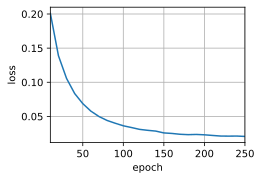

In [5]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

模型训练后，我们用它[**将几个英语句子翻译成法语**]并计算它们的 BLEU 分数。


In [6]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => <unk> chiens aboient .,  bleu 0.000
i'm home . => je suis chez moi .,  bleu 1.000


In [7]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

训练结束后通过[**可视化注意力权重**]，我们可以看到，每个查询都会在键值对上分配不同的权重。它显示，在每个解码步中，输入序列的不同部分被选择性地聚集在注意力池中。


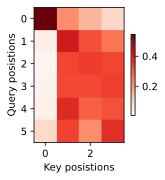

In [8]:
# 加上一个包含序列结束词元
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key posistions', ylabel='Query posistions')

## 小结

* 在预测词元时，如果不是所有输入词元都是相关的，那么具有 Bahdanau 注意力的循环神经网络编码器-解码器会有选择地统计输入序列的不同部分。这是通过将上下文变量视为加性注意力池化的输出来实现的。
* 在循环神经网络编码器-解码器中，Bahdanau 注意力将上一个时间步的解码器隐藏状态视为查询，在所有时间步的编码器隐藏状态同时视为键和值。

## 练习

1. 在实验中用 LSTM 替换 GRU。
1. 修改实验以将加性注意力打分函数替换为缩放点积注意力。它如何影响训练效率？


[Discussions](https://discuss.d2l.ai/t/1065)
